# Содержание #

<a id='import_libs'></a>
# Импорт библиотек #

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px
import plotly.figure_factory as ff
import warnings
import numpy as np
import scipy.stats as st
from IPython.core.display import display

warnings.filterwarnings('ignore')

<a id='data'></a>
# Данные #

In [2]:
data = pd.read_csv(filepath_or_buffer='datasets/games.csv')

<a id='data_view'></a>
## Первичный осмотр данных ##

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
data

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


# Результаты первичного осмотра данных #
1. перевести название столбцов в нижний регистр
2. перевести строковые значения в нижний регистр, удалить лишние символы
3. data['Name'] удалить строки содержащие NaN
4. data['Plaform'] привести к типу 'category'
5. data['Year_of_Release']
    * обогатить на основании названия игры
    * заменить пропуски на 'undefined'
6. data['Genre']
    * привести к типу 'category'
7. data['Critic_Score']
    * заменить пропущенные значения на 0
8. data['User_Score']
    * заменить пропущенные значения на 0
    * привести к типу int
    * привести значения к масштабу data['Critic_score']
9. data['Rating'] привести к типу 'category'

<a id='prepare'></a>
# Предобработка данных #

<a id='prepare_columns'></a>
## Переименование столбцов ##

In [5]:
data.columns = data.columns.str.lower()
data.columns = data.columns.str.strip()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


<a id='prepare_string'></a>
## Обработка строковых значений ##

In [6]:
def prepare_string():
    for column in data.columns:
        if data.dtypes[column] == 'object':
            data[column] = data[column].str.lower()
            data[column] = data[column].str.strip()

prepare_string()

## Удаление строк с пропусками data['name']

In [7]:
data.dropna(subset=['name'], inplace=True)
data.isna().sum()

name                  0
platform              0
year_of_release     269
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         6699
rating             6764
dtype: int64

<a id='prepare_year_of_release'></a>
## Обогащение data['year_of_release'] ##

In [8]:
year_range = range(data['year_of_release'].min().astype('int'), data['year_of_release'].max().astype('int'))

def year_update(raw):
    if np.isnan(raw['year_of_release']):
        for word in raw['name'].split(' '):
            if word.isnumeric() and pd.to_numeric(word) in year_range:
                return pd.to_numeric(word) - 1
    else: return pd.to_numeric(raw['year_of_release'])

data['year_of_release'] = data.apply(year_update, axis=1)
data['year_of_release'] = data['year_of_release'].fillna(np.NaN)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16459 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


<a id='prepare_tbd_user_score'></a>
## Замена значения "tbd" data['user_score'] ##
Пояснение: данные на основе которых можно заменить значение "tbd" отсутствуют => проведем замену на Nan

In [9]:
data['user_score'] = data['user_score'].replace(to_replace='tbd',
                                                value=np.NaN)

<a id='prepare_user_score'></a>
## Изменение типа данных data['user_score'], масштабирование данных ##

In [10]:
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce') * 10
print(data.info())
print(data['user_score'].unique())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16459 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: float64(7), object(4)
memory usage: 1.5+ MB
None
[80. nan 83. 85. 66. 84. 86. 77. 63. 74. 82. 90. 79. 81. 87. 71. 34. 53.
 48. 32. 89. 64. 78. 75. 26. 72. 92. 70. 73. 43. 76. 57. 50. 91. 65. 88.
 69. 94. 68. 61. 67. 54. 40. 49. 45. 93. 62. 42. 60. 37. 41. 58. 56. 55.
 44. 46. 59. 39. 

## Проверка гипотезы об идентичности data['user_score'], data['critic_score'] ##
$H_0:$ рейтинг критиков совпадает с рейтингом пользователей

$H_1:$ рейтинг критиков не совпадает с рейтингом пользователей

In [11]:
critics_score = data.query('~critic_score.isna()')['critic_score']
users_score = data.query('~user_score.isna()')['user_score']
print(critics_score.shape[0])
print(users_score.shape[0])

8137
7590


In [12]:
alpha = .05
result = st.ttest_ind(critics_score,
                      users_score,
                      equal_var=False)
print(f'Pvalue: {result.pvalue}')
if result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Pvalue: 6.731311703095746e-23
Отвергаем нулевую гипотезу


<a id='prepare_change_type'></a>
## Изменение типов данных ##

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16459 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: float64(7), object(4)
memory usage: 1.5+ MB


In [14]:
#data['platform'] = data['platform'].astype('category')
data['genre'] = data['genre'].astype('category')
data['rating'] = data['rating'].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             16713 non-null  object  
 1   platform         16713 non-null  object  
 2   year_of_release  16459 non-null  float64 
 3   genre            16713 non-null  category
 4   na_sales         16713 non-null  float64 
 5   eu_sales         16713 non-null  float64 
 6   jp_sales         16713 non-null  float64 
 7   other_sales      16713 non-null  float64 
 8   critic_score     8137 non-null   float64 
 9   user_score       7590 non-null   float64 
 10  rating           9949 non-null   category
dtypes: category(2), float64(7), object(2)
memory usage: 1.3+ MB


<a id='prepare_total_sales'></a>
## Подсчет суммарных продаж во всех регионах ##

In [15]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data['total_sales'].head()

0    82.54
1    40.24
2    35.52
3    32.77
4    31.38
Name: total_sales, dtype: float64

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             16713 non-null  object  
 1   platform         16713 non-null  object  
 2   year_of_release  16459 non-null  float64 
 3   genre            16713 non-null  category
 4   na_sales         16713 non-null  float64 
 5   eu_sales         16713 non-null  float64 
 6   jp_sales         16713 non-null  float64 
 7   other_sales      16713 non-null  float64 
 8   critic_score     8137 non-null   float64 
 9   user_score       7590 non-null   float64 
 10  rating           9949 non-null   category
 11  total_sales      16713 non-null  float64 
dtypes: category(2), float64(8), object(2)
memory usage: 1.4+ MB


<a id='prepare_duplicated'></a>
## Поиск дубликатов ##

In [17]:
data.duplicated().sum()

0

## Итоги предобработки данных ##
1. дубликаты отсутствуют
2. имена столбцов переведены в нижний регистр, лишние символы удалены
3. строковые значения переведены в нижний регистр, лишние символы удалены
4. приведены к типу 'category':
    * data['genre']
    * data['rating']
5. обогащение data['user_score'] на основе data['critic_score'] невозможно
6. обогащение data['critic_score'] на основе data['user_score'] невозможно
7. data['user_score']:
    * значение 'tbd' заменено на np.NaN
    * проведено масштабирование данных
8. data['year_of_release']:
    * проведено обогащение на основе data['name']
    * пропущенные значения заменены на np.NaN
9. data['name']:
    * строки с пропущенными значениями удалены
10. data['total_sales']:
    * добавлен столбец с суммарными продажами во всех регионах

<a id='analyze'></a>
# Исследовательский анализ данных #

<a id='analyze_total_games'></a>
## График выхода игр ##

In [18]:
pivot_games_count_year = data.pivot_table(index='year_of_release',
                                          values='name',
                                          aggfunc='count')

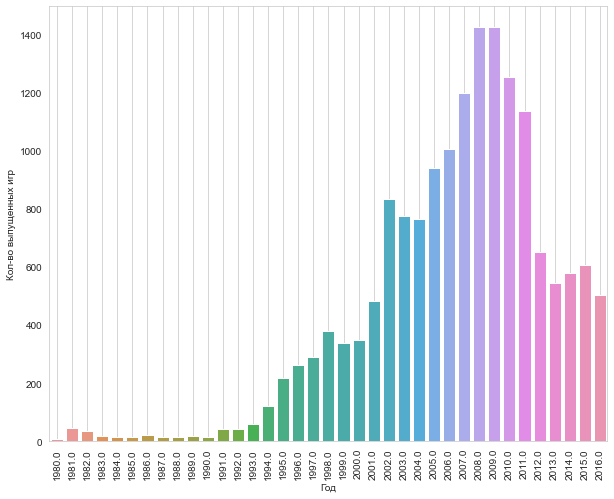

In [19]:
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x=pivot_games_count_year.index,
            y=pivot_games_count_year.name,
            ax=ax)
plt.grid()
plt.xticks(rotation=90)
plt.xlabel('Год')
plt.ylabel('Кол-во выпущенных игр')
plt.show()

## Результаты осмотра графика выхода игр ##
1. пиковые значения количества выпускаемых на рынок игр фиксируются в 2008 и 2009.

<a id='analyze_platform_sales'></a>
## График продаж игр для платформ ##

In [20]:
pivot_platform_games_sales = data.pivot_table(index=['year_of_release', 'platform'],
                                              values='total_sales',
                                              aggfunc='sum').\
                             sort_values(by='year_of_release', ascending=False).\
                             reset_index()

fig = px.line(data_frame=pivot_platform_games_sales,
              x='year_of_release',
              y='total_sales',
              color='platform',
              labels={'total_sales':'Кол-во проданных копий, млн. шт.',
                      'year_of_release':'Год выпуска',
                      'platform':'Платформа'})
fig.update_layout(title_text='График продаж игр для платформ', title_x=0.5)
fig.show()

## Результаты осмотра продаж игр для платформ ##
1. средний срок активных продаж игр для платформы составляет 8-10 лет
2. пик продаж игр для платформы наблюдается в середине жизненного цикла платформы
3. для поиска актуальных платформ необходимо использовать данные с 2011

<a id='analyze_actual_platform'></a>
## График мировых продаж игр для платформ с 2011 года ##

In [21]:
pivot_actual_platform = pivot_platform_games_sales.query('year_of_release >= 2011 and total_sales >= 1')

fig = px.line(data_frame=pivot_actual_platform,
              x='year_of_release',
              y='total_sales',
              color='platform',
              labels={'total_sales':'Кол-во проданных копий, млн. шт.',
                      'year_of_release':'Год выпуска',
                      'platform':'Платформа'})
fig.update_layout(title_text='График мировых продаж игр для платформ с 2011 года', title_x=0.5)
fig.show()

## Результаты осмотра графика мировых продаж игр для платформ с 2011 года ##
1. актуальные платформы:
    * xone
    * ps4
    * 3ds
    * pc
2. покидающие рынок платформы:
    * psv
    * wiiu
    * x360
    * ps3
3. продажи в 2016 году:
    * xone = 26.15 млн. копий
    * ps4 = 69.25 млн. копий
    * 3ds = 15.14 млн. копий
    * pc = 5.25 млн. копий
    * psv = 4.25 млн. копий
    * wiiu = 4.6 млн. копий
    * x360 = 1.52 млн. копий
    * ps3 = 3.6 млн. копий

<a id='analyze_platform_boxplot'></a>
## Диаграмма размаха мировых продаж по перспективным платформам ##

In [22]:
platform_dict = ["pc", "xone", "ps4", "3ds"]
pivot_actual_platform = pivot_actual_platform.query('platform in @platform_dict')

In [23]:
fig = px.box(data_frame=pivot_actual_platform,
             x='platform',
             y='total_sales',
             color='platform',
             labels={'total_sales':'Объем продаж',
                     'platform':'Платформа'})
fig.update_layout(title_text='Диграмма размаха продаж для перспективных платформ',
                  title_x=0.5)
fig.show()

## Результаты осмотра диграммы размаха мировых продаж игр для перспективных платформ ##
1. xone:
    * медианное значение проданных копий = 40.11 млн. копий
    * максимальное значение проданных копий = 60.14 млн. копий
2. 3ds:
    * медианное значение проданных копий = 47.56 млн. копий
    * максимальное значение проданных копий = 63.2 млн. копий
3. ps4:
    * медианное значение проданных копий = 84.63 млн. копий
    * максимальное значение проданных копий = 118.9 млн. копий
4. pc:
    * медианное значение проданных копий = 12.83 млн. копий
    * максимальное значение проданных копий = 35.03 млн. копий

<a id='analyze_corr_sales_score'></a>
## Корреляция количества проданных копий с рейтингом критиков/пользователей ##

In [54]:
for _ in platform_dict:
    fig = px.imshow(data.query('platform == @_ and year_of_release >= 2011')[['total_sales', 'critic_score', 'user_score']].corr(),
                    aspect='auto')
    fig.update_layout(title=f'Корреляция количества проданных копий с рейтингом критиков/пользователей для {_}',
                      title_x=0.5)
    fig.show()

## Результаты осмотра корреляции мировых продаж с рейтингом критиков/игроков ##
1. pc:
    * оценки критиков: слабая, положительная связь
    * оценки пользователей: очень слабая отрицательная связь
2. xone:
    * оценки критиков: слабая, положительная связь
    * оценки пользователей: слабая, отрицательная связь
3. ps4:
    * оценки критиков: слабая, положительная связь
    * оценки пользователей: слабая, отрицательная связь
4. 3ds:
    * оценки критиков: слабая, положительная связь
    * оценки пользователей: слабая, положительная связь

<a id='analyze_games_genre'></a>
## Распределение продаж по жанрам ##

In [52]:
data_actual = data.query('year_of_release >= 2011 and platform in @platform_dict')
data_actual.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,call of duty: black ops 3,ps4,2015.0,shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
33,pokemon x/pokemon y,3ds,2013.0,role-playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
40,mario kart 7,3ds,2011.0,racing,5.03,4.02,2.69,0.91,85.0,82.0,e,12.65
42,grand theft auto v,ps4,2014.0,action,3.96,6.31,0.38,1.97,97.0,83.0,m,12.62
47,pokemon omega ruby/pokemon alpha sapphire,3ds,2014.0,role-playing,4.35,3.49,3.10,0.74,NaN,NaN,NaN,11.68
...,...,...,...,...,...,...,...,...,...,...,...,...
16678,end of nations,pc,2012.0,strategy,0.01,0.00,0.00,0.00,NaN,NaN,t,0.01
16688,outdoors unleashed: africa 3d,3ds,2011.0,sports,0.01,0.00,0.00,0.00,NaN,NaN,t,0.01
16692,metal gear solid v: ground zeroes,pc,2014.0,action,0.00,0.01,0.00,0.00,80.0,76.0,m,0.01
16696,breach,pc,2011.0,shooter,0.01,0.00,0.00,0.00,61.0,58.0,t,0.01


In [53]:
fig = px.bar(data_frame=data_actual.pivot_table(index=['platform','genre'],
                                                values='total_sales',
                                                aggfunc='sum').reset_index(),
             x='platform',
             y='total_sales',
             color='genre',
             barmode='group',
             text_auto=True,
             labels={'genre':'Жанр',
                     'total_sales':'Кол-во проданных копий',
                     'platform':'Платформа'})
fig.update_layout(title='График продаж игр по жанрам, в рамках платформ',
                  title_x=0.5)
fig.show()

## Результаты осмотра графика распределения продаж по жарнрам ##
1. xone:
   * жанры лидеры:
     - shooter
     - action
     - sports
   * жанры аутсайдеры:
     - strategy
     - simulation
     - platform
     - puzzle
2. ps4:
    * жанры лидеры:
      - action
      - shooter
      - sports
    * жанры аутсайдеры:
      - puzzle
      - strategy
      - simulation
3. pc:
    * жанры лидеры:
      - shooter
      - role-playing
      - action
    * жанры аутсайдеры:
      - fighting
      - platform
      - puzzle
4. 3ds:
    * жанры лидеры:
      - role-playing
      - action
      - platform
    * жанры аутсайдеры:
      - shooter
      - strategy
      - adventure


<a id='region_user'><a/>
# Пользовательские портреты #

<a id='region_user_na'></a>
## Северная Америка ##